In [32]:
from rdkit.Chem import AllChem as Chem
import pickle
import pandas as pd
import numpy as np
from rdkit import DataStructs
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import itertools
import os

%matplotlib inline

In [4]:
prot_dist, targets, lig_sim = pickle.load(open('../fullbdb_external_simi.pickle', 'rb'))
better_targets = [target.split('_')[0] for target in targets]
external_targets = better_targets[-209:]
external_ind = list(range(len(targets) - len(external_targets), len(targets)))
set_ext_targs = list(set(external_targets))

In [5]:
simi_ligs = {target:[] for target in set_ext_targs}
for ex_idx, target in zip(external_ind,set_ext_targs):
    print(ex_idx, target)
    same_target = [i for i,x in enumerate(better_targets) if x == target]
    cur_prot_dist = np.delete(prot_dist[same_target[0]],same_target)
    min_prot_dist = min(cur_prot_dist)
    max_simi = [0 for lig in same_target]
    simi_ligs[target] = ['' for lig in same_target]
    for idx, lig in enumerate(same_target):
        cur_lig_sim = np.delete(lig_sim[lig],same_target)
        max_lig_sim = max(cur_lig_sim)
        if max_lig_sim > max_simi[idx]:
            max_simi[idx] = max_lig_sim
            simi_ligs[target][idx] = targets[np.argmax(cur_lig_sim)]

8858 JNK1
8859 BRD4
8860 MCL1
8861 CDK2
8862 P38
8863 BACE
8864 Thrombin
8865 TYK2
8866 PTP1B


In [6]:
bdb_data = pd.read_csv('all_newdata.types',sep=' ',header=None)
bdb_data.columns = ['cls','ddg','dg1','dg2','rec','lig1','lig2']
bdb_data['recname'] = bdb_data['rec'].apply(lambda x: x.split('_')[0])

In [7]:
def getExtIntPairs(external):
    data = pd.read_csv(f'../external_test/{external}/{external}_DDG.types',sep=' ',header=None)
    data.columns = ['cls','ddg','dg1','dg2','rec','lig1','lig2']
    data['lig1 smi'] = data['lig1'].apply(lambda x: '../external_test/' + x.replace('.sdf','.smi'))

    ligs = simi_ligs[external]
    bdb_gp = bdb_data.groupby('recname')
    potential_ligs = []
    for item in ligs:
        prop_gp = bdb_gp.get_group(item.split('_')[0])
        potential_ligs += prop_gp['lig1'].tolist()
    potential_ligs = list(set(potential_ligs))

    ext_ligs = [(Chem.MolFromSmiles(open(smi,'r').read()),smi) for smi in data['lig1 smi'].unique().tolist()]
    p_ligs = [(Chem.MolFromMol2File('BDB_docked/' + lig.replace('_0.gninatypes','.mol2')),lig.replace('_0.gninatypes','')) for lig in potential_ligs]

    bdb_cong = {targ.split('_')[0]:dict() for _, targ in p_ligs}
    eseries = dict()
    bdb_ligs = []
    for elig, ename in ext_ligs:
        efing = Chem.RDKFingerprint(elig)
        e_dg = data[data['lig1 smi'] == ename]['dg1'].tolist()[0]
        eseries[ename] = e_dg
        for bdblig, bdbname in p_ligs:
            bfing = Chem.RDKFingerprint(bdblig)
            result = DataStructs.FingerprintSimilarity(efing,bfing)
            if result == 1:
                b_dg = bdb_data[bdb_data['lig1'] == (bdbname + '_0.gninatypes')]['dg1'].tolist()[0]
                bdb_ligs.append((ename,e_dg,bdbname,b_dg))
                bdb_cong[bdbname.split('_')[0]][bdbname] = b_dg
    return pd.DataFrame(bdb_ligs,columns=['ext lig','ext DG','BDB lig','BDB DG'])

In [8]:
cdk2_data = pd.read_csv('../external_test/CDK2/CDK2_DDG.types',sep=' ',header=None)
cdk2_data.columns = ['cls','ddg','dg1','dg2','rec','lig1','lig2']
cdk2_data['lig1 smi'] = cdk2_data['lig1'].apply(lambda x: '../external_test/' + x.replace('.sdf','.smi'))
cdk2_data

,cls,ddg,dg1,dg2,rec,lig1,lig2,lig1 smi
0,0,-1.2340,5.1811,6.4151,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG15.sdf,CDK2/CDK2_LIG13.sdf,../external_test/CDK2/CDK2_LIG15.smi
1,0,-0.5791,5.1811,5.7602,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG15.sdf,CDK2/CDK2_LIG9.sdf,../external_test/CDK2/CDK2_LIG15.smi
2,0,-0.6041,5.1811,5.7852,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG15.sdf,CDK2/CDK2_LIG14.sdf,../external_test/CDK2/CDK2_LIG15.smi
3,0,-1.0228,5.1811,6.2039,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG15.sdf,CDK2/CDK2_LIG10.sdf,../external_test/CDK2/CDK2_LIG15.smi
4,0,-2.9956,5.1811,8.1767,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG15.sdf,CDK2/CDK2_LIG2.sdf,../external_test/CDK2/CDK2_LIG15.smi
...,...,...,...,...,...,...,...,...
235,1,1.1818,7.2002,6.0185,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG3.sdf,CDK2/CDK2_LIG16.sdf,../external_test/CDK2/CDK2_LIG3.smi
236,1,1.5570,7.2002,5.6432,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG3.sdf,CDK2/CDK2_LIG8.sdf,../external_test/CDK2/CDK2_LIG3.smi
237,0,-1.0751,7.2002,8.2753,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG3.sdf,CDK2/CDK2_LIG11.sdf,../external_test/CDK2/CDK2_LIG3.smi
238,1,0.0324,7.2002,7.1678,CDK2/CDK2_PROT.pdb,CDK2/CDK2_LIG3.sdf,CDK2/CDK2_LIG4.sdf,../external_test/CDK2/CDK2_LIG3.smi


In [9]:
ligs = simi_ligs['CDK2']
bdb_gp = bdb_data.groupby('recname')
potential_ligs = []
for item in ligs:
    prop_gp = bdb_gp.get_group(item.split('_')[0])
    potential_ligs += prop_gp['lig1'].tolist()
    print(prop_gp.head())
potential_ligs = list(set(potential_ligs))

       cls     ddg     dg1     dg2                         rec  \
20722    1  0.3750  6.0132  5.6383  1H1Q_2A6/1H1Q_0.gninatypes   
20723    1  0.8457  6.0132  5.1675  1H1Q_2A6/1H1Q_0.gninatypes   
20724    1  1.0924  6.0132  4.9208  1H1Q_2A6/1H1Q_0.gninatypes   
20725    0 -0.3847  6.0132  6.3979  1H1Q_2A6/1H1Q_0.gninatypes   
20726    1  0.2685  6.0132  5.7447  1H1Q_2A6/1H1Q_0.gninatypes   

                                          lig1  \
20722  1H1Q_2A6/1H1Q-results_5530_0.gninatypes   
20723  1H1Q_2A6/1H1Q-results_5530_0.gninatypes   
20724  1H1Q_2A6/1H1Q-results_5530_0.gninatypes   
20725  1H1Q_2A6/1H1Q-results_5530_0.gninatypes   
20726  1H1Q_2A6/1H1Q-results_5530_0.gninatypes   

                                          lig2 recname  
20722  1H1Q_2A6/1H1Q-results_5531_0.gninatypes    1H1Q  
20723  1H1Q_2A6/1H1Q-results_5533_0.gninatypes    1H1Q  
20724  1H1Q_2A6/1H1Q-results_5534_0.gninatypes    1H1Q  
20725  1H1Q_2A6/1H1Q-results_5536_0.gninatypes    1H1Q  
20726  1H1Q_2A6/1

In [10]:
cdk2_ligs = [(Chem.MolFromSmiles(open(smi,'r').read()),smi) for smi in cdk2_data['lig1 smi'].unique().tolist()]
p_ligs = [(Chem.MolFromMol2File('BDB_docked/' + lig.replace('_0.gninatypes','.mol2')),lig.replace('_0.gninatypes','')) for lig in potential_ligs]

In [11]:
bdb_ligs = []
for clig, cname in cdk2_ligs:
    cfing = Chem.RDKFingerprint(clig)
    for bdblig, bdbname in p_ligs:
        bfing = Chem.RDKFingerprint(bdblig)
        result = DataStructs.FingerprintSimilarity(cfing,bfing)
        if result == 1:
           bdb_ligs.append((cname,bdbname))

In [12]:
bdb_cong = {targ.split('_')[0]:dict() for _, targ in bdb_ligs}
cseries = dict()
for clig, blig in bdb_ligs:
    c_dg = cdk2_data[cdk2_data['lig1 smi'] == clig]['dg1'].tolist()[0]
    cseries[clig] = c_dg
    b_dg = bdb_data[bdb_data['lig1'] == (blig + '_0.gninatypes')]['dg1'].tolist()[0]
    bdb_cong[blig.split('_')[0]][blig] = b_dg
    print(c_dg,b_dg)

5.1811 5.1675
5.1811 5.1675
6.4151 6.3979
6.4151 6.3979
5.7602 5.7447
5.7602 5.7447
5.7852 5.7696
5.7852 5.7696
6.2039 6.1871
6.2039 6.1871
6.2039 6.1871
8.1767 8.1549
7.2716 7.2518
7.2201 7.2007
7.0192 7.0
7.0192 7.0
7.1745 7.1549
6.0185 6.0132
6.0185 6.0132
6.0185 6.0132
5.6432 5.6383
8.2753 8.1871
7.1678 7.1612
7.1678 7.1612
7.1678 7.1612
6.6837 6.6778
7.2002 7.1938


In [13]:
calc_c = []
calc_b = []
for key in bdb_cong.keys():
    for clig, blig in bdb_ligs:
        if blig in bdb_cong[key].keys():
            calc_c.append(cseries[clig])
            calc_b.append(bdb_cong[key][blig])
    print(f"{key}:{pearsonr(calc_c,calc_b)[0]}")

1H1S:0.9998206918224162
1H1Q:0.9998632445025962
1OIY:0.9998556431043294


# Looking at Final Relationship between External and BDB

2H4G:0.9999948355674627 (3)
2QBQ:0.9996298434000507 (11)
2QBR:0.9997267392580895 (14)
2QBP:0.9999972620739117 (4)
2B07:0.9999997226259901 (3)


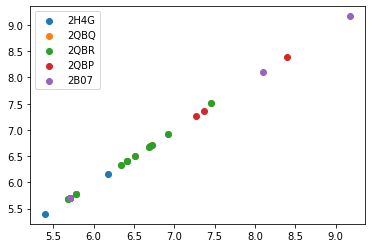

In [14]:
PTP1B_DF = getExtIntPairs('PTP1B')
PTP1B_DF['series'] = PTP1B_DF['BDB lig'].apply(lambda x: x.split('_')[0])
ptp_gp = PTP1B_DF.groupby('series')
for ser in PTP1B_DF.series.unique().tolist():
    gp = ptp_gp.get_group(ser)
    print(f"{ser}:{pearsonr(gp['ext DG'],gp['BDB DG'])[0]} ({gp.shape[0]})")
    plt.scatter(gp['ext DG'],gp['BDB DG'],label=ser)
plt.legend()

In [173]:
sdict = {ser:set(ptp_gp.get_group(ser)['ext lig'].tolist()) for ser in PTP1B_DF.series.unique().tolist()}
sdict.keys()
for key in sdict.keys():
    for key2 in sdict.keys():
        if key == key2:
            continue
        else:
            print(f"{key},{key2}:{len(sdict[key].intersection(sdict[key2]))}")

2H4G,2QBQ:1
2H4G,2QBR:1
2H4G,2QBP:0
2H4G,2B07:0
2QBQ,2H4G:1
2QBQ,2QBR:11
2QBQ,2QBP:0
2QBQ,2B07:0
2QBR,2H4G:1
2QBR,2QBQ:11
2QBR,2QBP:0
2QBR,2B07:0
2QBP,2H4G:0
2QBP,2QBQ:0
2QBP,2QBR:0
2QBP,2B07:1
2B07,2H4G:0
2B07,2QBQ:0
2B07,2QBR:0
2B07,2QBP:1


1H1S:0.9998206918224162 (13)
1H1Q:0.9999632010541726 (9)
1OIY:0.9999510530145312 (5)


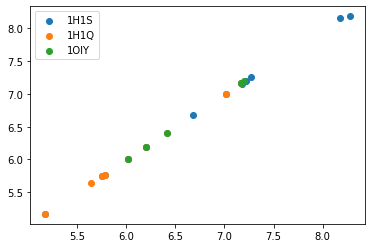

In [16]:
CDK2_DF = getExtIntPairs('CDK2')
CDK2_DF['series'] = CDK2_DF['BDB lig'].apply(lambda x: x.split('_')[0])
cdk2_gp = CDK2_DF.groupby('series')
for ser in CDK2_DF.series.unique().tolist():
    gp = cdk2_gp.get_group(ser)
    print(f"{ser}:{pearsonr(gp['ext DG'],gp['BDB DG'])[0]} ({gp.shape[0]})")
    plt.scatter(gp['ext DG'],gp['BDB DG'],label=ser)
plt.legend()

In [180]:
sdict = {ser:set(cdk2_gp.get_group(ser)['ext lig'].tolist()) for ser in CDK2_DF.series.unique().tolist()}
sdict.keys()
for key in sdict.keys():
    for key2 in sdict.keys():
        if key == key2:
            continue
        else:
            print(f"{key}({len(sdict[key])}),{key2}({len(sdict[key2])}):{len(sdict[key].intersection(sdict[key2]))}")

1H1S(13),1H1Q(9):7
1H1S(13),1OIY(5):3
1H1Q(9),1H1S(13):7
1H1Q(9),1OIY(5):4
1OIY(5),1H1S(13):3
1OIY(5),1H1Q(9):4


In [181]:
sdict

{'1H1S': {'../external_test/CDK2/CDK2_LIG1.smi',
  '../external_test/CDK2/CDK2_LIG10.smi',
  '../external_test/CDK2/CDK2_LIG11.smi',
  '../external_test/CDK2/CDK2_LIG12.smi',
  '../external_test/CDK2/CDK2_LIG14.smi',
  '../external_test/CDK2/CDK2_LIG15.smi',
  '../external_test/CDK2/CDK2_LIG16.smi',
  '../external_test/CDK2/CDK2_LIG2.smi',
  '../external_test/CDK2/CDK2_LIG4.smi',
  '../external_test/CDK2/CDK2_LIG5.smi',
  '../external_test/CDK2/CDK2_LIG6.smi',
  '../external_test/CDK2/CDK2_LIG7.smi',
  '../external_test/CDK2/CDK2_LIG9.smi'},
 '1H1Q': {'../external_test/CDK2/CDK2_LIG10.smi',
  '../external_test/CDK2/CDK2_LIG12.smi',
  '../external_test/CDK2/CDK2_LIG13.smi',
  '../external_test/CDK2/CDK2_LIG14.smi',
  '../external_test/CDK2/CDK2_LIG15.smi',
  '../external_test/CDK2/CDK2_LIG16.smi',
  '../external_test/CDK2/CDK2_LIG4.smi',
  '../external_test/CDK2/CDK2_LIG8.smi',
  '../external_test/CDK2/CDK2_LIG9.smi'},
 '1OIY': {'../external_test/CDK2/CDK2_LIG10.smi',
  '../external_tes

In [33]:
def permsToCombos(df_loc):
    df = pd.read_csv(df_loc,sep=' ',header=None)
    df.columns = ['cls','reg','dg1','dg2','rec','lig1','lig2','pred']
    ligs = list(set(df.lig1.unique().tolist() + df.lig2.unique().tolist()))
    single_order_list = list(itertools.combinations(ligs,2))
    single_order_ligs = pd.DataFrame(single_order_list,columns=['lig1','lig2'])
    single_order_df = df.merge(single_order_ligs,how='inner',on=['lig1','lig2'])
    print(df_loc)
    combo_df_loc =f'{os.path.splitext(df_loc)[0]}_combos.types'
    single_order_df.to_csv(combo_df_loc,header=False,sep=' ',index=False)
    return combo_df_loc


../external_test/CDK2/CDK2_DDGpreds.types
../external_test/PTP1B/PTP1B_DDGpreds.types


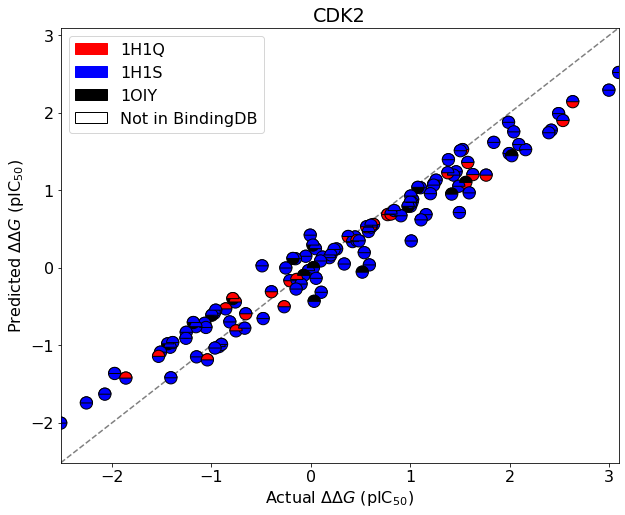

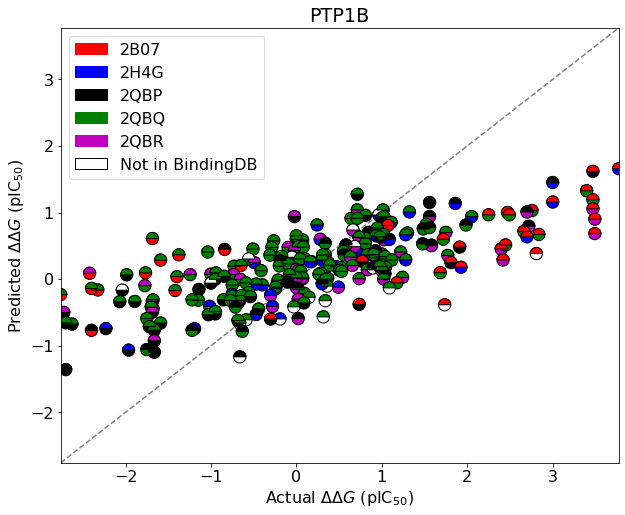

In [191]:
matplotlib.rc('font',size=16)
def not_present():
    return "ZNothing"
for external_set in ['CDK2','PTP1B']:
    DF = getExtIntPairs(external_set)
    DF['series'] = DF['BDB lig'].apply(lambda x: x.split('_')[0])
    new_loc = permsToCombos(f'../external_test/{external_set}/{external_set}_DDGpreds.types')
    combos_preds = pd.read_csv(new_loc,sep=' ',header=None,names=['cls','ddg','dg1','dg2','rec','lig1','lig2','pred'])
    DF['ext lig gt'] = DF['ext lig'].apply(lambda x: os.path.splitext(x.replace('../external_test/',''))[0] + '.sdf')
    lig_to_series = defaultdict(not_present)
    if external_set == 'CDK2':
        DF['series'] = pd.Categorical(DF['series'],['1H1S','1H1Q','1OIY'])
    elif external_set == 'PTP1B':
        DF['series'] = pd.Categorical(DF['series'],["2QBQ","2QBR","2QBP","2H4G","2B07"])
    lig_to_series = DF.sort_values('series',ascending=False).set_index('ext lig gt')['series'].to_dict(lig_to_series)
    color_map = {pdbid: c for pdbid,c in zip(sorted(DF.series.unique()) + [ "ZNothing" ],['r','b','k','g','m','white'])} 
    patches = [ mpatches.Patch(color=value, label="{:s}".format(key) ) for key,value in color_map.items()  if key != "ZNothing"]
    patches += [ mpatches.Patch(facecolor="white", label="Not in BindingDB", edgecolor='k' )]
    size=150
    fig= plt.figure(figsize=(10,8))
    ax = fig.gca()
    plt.title(external_set)
    plt.scatter(combos_preds['ddg'],combos_preds['pred'],s=size,
            edgecolor='k',
            marker=matplotlib.markers.MarkerStyle(marker='o'),
            c=combos_preds['lig2'].map(lig_to_series).map(color_map).tolist())
    plt.scatter(combos_preds['ddg'],combos_preds['pred'],s=size,
            marker=matplotlib.markers.MarkerStyle(marker='o',fillstyle='top'),
            edgecolor='k',
            c=combos_preds['lig1'].map(lig_to_series).map(color_map).tolist(),
            facecolor=combos_preds['lig2'].map(lig_to_series).map(color_map).tolist())
    ax.set_xlim(min(combos_preds['ddg']),max(combos_preds['ddg']))
    ax.set_ylim(min(combos_preds['ddg']),max(combos_preds['ddg']))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',zorder=-1,c='grey')
    plt.xlabel('Actual $\Delta\Delta G$ ($\mathrm{pIC}_{50}$)')
    plt.ylabel('Predicted $\Delta\Delta G$ ($\mathrm{pIC}_{50}$)')
    plt.legend(handles=patches)
    plt.savefig(f'../figs/{external_set}_pred_actual.pdf',dpi=300)